In [4]:
import numpy as np
import tensorflow as tf
#import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os

In [5]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices()

2.4.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
classes = np.array(["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"])
classes_tensor = tf.convert_to_tensor(classes)

In [12]:
dataset_path = "/mnt/3206BFFF191E7F85/UrbanSound8K/audio/"
folders = os.listdir(dataset_path)
train_files = []
for fold in os.listdir(dataset_path)[2:]:
  files = os.listdir(os.path.join(dataset_path, fold))
  for i,f in enumerate(files):
    files[i] = dataset_path+fold+"/"+f
  train_files.extend(files)

In [8]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary, desired_samples=128000, desired_channels=1)
  return tf.squeeze(audio, axis=-1)

In [9]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  filename = parts[-1]
  splitted = tf.strings.split(filename, "-")
  classID = splitted[1]
  classID = tf.strings.to_number(classID, tf.int32)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return classes_tensor[classID]

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label


In [18]:
AUTOTUNE = -1
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [35]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([128000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [36]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

/home/andrea/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


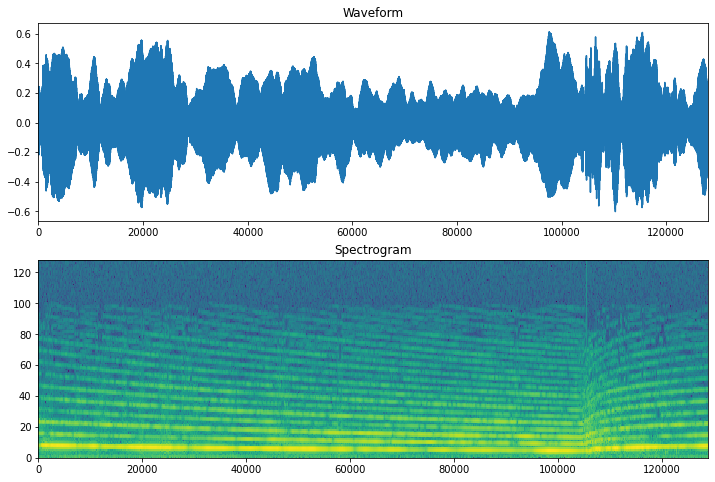

In [38]:
wf, _ = get_waveform_and_label(train_files[0])
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(wf.shape[0])
axes[0].plot(timescale, wf.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 128000])
plot_spectrogram(get_spectrogram(wf).numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [40]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == classes)
  return spectrogram, label_id

In [41]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


In [42]:
batch_size = 64
train_ds = spectrogram_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)

In [43]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(classes)

Input shape: (64, 999, 129, 1)


In [44]:
del model

In [45]:
model = models.Sequential([
    layers.Input(shape=(999,129,1)),
    preprocessing.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)            

In [46]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [47]:
EPOCHS = 100
history = model.fit(
    train_ds,
    epochs=EPOCHS,
)

Epoch 1/100
90/90 [==============================] - 4s 47ms/step - loss: 2.2983 - accuracy: 0.1056

KeyboardInterrupt: 

In [15]:
errors = 0
waste = []
for index, file in enumerate(train_files):
    audio_binary = tf.io.read_file(file)
    try:
        waveform = decode_audio(audio_binary)
    except tf.errors.InvalidArgumentError:
        waste.append(index)

OTHER

In [17]:
for corrupted in waste[::-1]:
    del train_files[corrupted]

In [29]:
batch_size = 64
def float_wf(waveform):
    waveform = tf.cast(waveform, tf.float32)
    return waveform
def float_wf_and_label(audio, label):
  spectrogram = float_wf(audio)
  #spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == classes)
  return spectrogram, label_id

In [31]:
train_ds = waveform_ds.map(
    float_wf_and_label, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)

In [26]:
from tensorflow.keras import layers
from tensorflow.keras import models
model = models.Sequential([
    layers.Input(shape=(128000,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                8192064   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)              

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [32]:
EPOCHS = 100
history = model.fit(
    train_ds,
    epochs=EPOCHS,
)

Epoch 1/100
82/82 [==============================] - 4s 48ms/step - loss: 2.3952 - accuracy: 0.1059

KeyboardInterrupt: 